In [28]:
# Dependencies
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# US Census setup
from census import Census
from us import states
from config import census_key

In [11]:
# Retrieve US censue data and create dataframe
census_library = Census(census_key, year=2021)
state_code = states.CA.fips
variables = [
    'NAME',
    'B01003_001E',  # Population
    'B25014_001E',  # Total Housing units
    'B25014_005E',  # Housing units owner occupied, 1-1.5 occupants per room
    'B25014_006E',  # Housing units owner occupied, 1.5-2 occupants per room
    'B25014_007E',  # Housing units owner occupied, >2 occupants per room
    'B25014_011E',  # Housing units renter occupied, 1-1.5 occupants per room
    'B25014_012E',  # Housing units renter occupied, 1.5-2 occupants per room
    'B25014_013E'   # Housing units renter occupied, >2 occupants per room   
    'B25106_003E',  # Housing units owner occupied, income <20K
    'B25106_006E',  # Housing units owner occupied, income <20K, housing costs >=30% of income
    'B25106_007E',  # Housing units owner occupied, income 20-35K
    'B25106_010E',  # Housing units owner occupied, income 20-35K, housing costs >=30% of income
    'B25106_011E',  # Housing units owner occupied, income 35-50K
    'B25106_014E',  # Housing units owner occupied, income 35-50K, housing costs >=30% of income
    'B25106_025E',  # Housing units renter occupied, income <20K
    'B25106_028E',  # Housing units renter occupied, income <20K, housing costs >=30% of income
    'B25106_029E',  # Housing units renter occupied, income 20-35K
    'B25106_032E',  # Housing units renter occupied, income 20-35K, housing costs >=30% of income
    'B25106_033E'   # Housing units renter occupied, income 35-50K, housing costs >=30% of income
]

# Retrieve data for all counties in California
data = census_library.acs5.state_county(variables, state_code, Census.ALL)

# Convert to dataframe
housing_df = pd.DataFrame(data)

# Export raw data to csv
url_path = Path('output_data/housing_raw_data.csv')
housing_df.to_csv(url_path, index=False)

# Print the DataFrame
housing_df.head()

,NAME,B01003_001E,B25106_002E,B25106_003E,B25106_006E,B25106_007E,B25106_010E,B25106_011E,B25106_014E,B25106_024E,B25106_025E,B25106_028E,B25106_029E,B25106_032E,B25106_033E,B25106_036E,state,county
0,"Alameda County, California",1673133.0,313410.0,12117.0,10897.0,15122.0,10589.0,14914.0,8546.0,268273.0,33224.0,29275.0,26673.0,24128.0,23024.0,19821.0,06,001
1,"Alpine County, California",1344.0,355.0,20.0,10.0,41.0,7.0,17.0,6.0,79.0,4.0,4.0,23.0,2.0,6.0,2.0,06,003
2,"Amador County, California",40095.0,12075.0,995.0,870.0,1230.0,685.0,1513.0,797.0,3319.0,568.0,513.0,449.0,449.0,393.0,269.0,06,005
3,"Butte County, California",217884.0,49549.0,4388.0,3418.0,5638.0,2988.0,4819.0,1809.0,35743.0,7396.0,6970.0,6850.0,6126.0,4921.0,3133.0,06,007
4,"Calaveras County, California",45349.0,13698.0,1220.0,1033.0,1458.0,1005.0,1595.0,867.0,3111.0,584.0,550.0,443.0,384.0,367.0,334.0,06,009


In [33]:
# Test for missing data
housing_df.count()

County                        58
Population                    58
Total Housing Units           58
Units Income < 50K            58
Units Costs >= 30%            58
% Units Inc<50K Costs>=30%    58
% Units Costs>=30%            58
dtype: int64

In [12]:
# Clean up data and add calculated columns

# Rename existing columns
housing_df = housing_df.rename(
    columns = {
        'NAME': 'County',
        'B01003_001E': 'Population',
        'B25014_001E': 'Total Housing Units'
    }
)

# Remove California from data in County column
housing_df['County'] = housing_df['County'].str.replace(', California','')

# Add columns rolling up data on overcrowded housing units
housing_df['Units Overcrowded'] = housing_df['B25014_005E'] + housing_df['B25014_011E']
housing_df['Units Severely Overcrowded'] = (housing_df['B25014_006E'] + housing_df['B25014_007E'] +
                                            housing_df['B25014_012E'] + housing_df['B25014_012E']
                                           )

# Add columns to calculate %s of overcrowded units
housing_test_df['% Units Overcrowded'] = housing_test_df['Units Overcrowded'] / housing_test_df['Total Housing Units'] * 100
housing_test_df['% Units Severely Overcrowded'] = housing_test_df['Units Severely Overcrowded'] / housing_test_df['Total Housing Units'] * 100
housing_test_df['% Units All Overcrowded'] = ((housing_test_df['Units Overcrowded'] + housing_test_df['Units Severely Overcrowded']) /
                                              housing_test_df['Total Housing Units']) * 100

# Add columns rolling up data on housing units based on housing costs and household income
housing_df['Units Income < 50K'] = (housing_df['B25106_003E'] + housing_df['B25106_007E'] +
                                    housing_df['B25106_011E'] + housing_df['B25106_025E'] +
                                    housing_df['B25106_029E'] + housing_df['B25106_033E']
                                   )
housing_df['Units Costs >= 30%'] = (housing_df['B25106_006E'] + housing_df['B25106_010E'] +
                                    housing_df['B25106_014E'] + housing_df['B25106_028E'] +
                                    housing_df['B25106_032E'] + housing_df['B25106_036E']
                                   )

# Add columns to calculate % of housing units with costs >= 30%
housing_df['% Units Inc<50K Costs>=30%'] = housing_df['Units Costs >= 30%'] / housing_df['Units Income < 50K'] * 100
housing_df['% Units Costs>=30%'] = housing_df['Units Costs >= 30%'] / housing_df['Total Housing Units'] * 100

# Remove unneeded columns
# https://sparkbyexamples.com/pandas/pandas-drop-columns-by-index/
housing_clean_df = housing_df.drop(housing_df.iloc[:, 3:22], axis = 1)

# Export clean data to csv
url_path = Path('output_data/housing_clean_data.csv')
housing_clean_df.to_csv(url_path, index=False)

# Print the dataframe
housing_clean_df.head()

,County,Population,Total Housing Units,Units Income < 50K,Units Costs >= 30%,% Units Inc<50K Costs>=30%,% Units Costs>=30%
0,Alameda County,1673133.0,581683.0,125074.0,103256.0,82.555927,17.751249
1,Alpine County,1344.0,434.0,111.0,31.0,27.927928,7.142857
2,Amador County,40095.0,15394.0,5148.0,3583.0,69.599845,23.275302
3,Butte County,217884.0,85292.0,34012.0,24444.0,71.868752,28.659194
4,Calaveras County,45349.0,16809.0,5667.0,4173.0,73.636845,24.825986


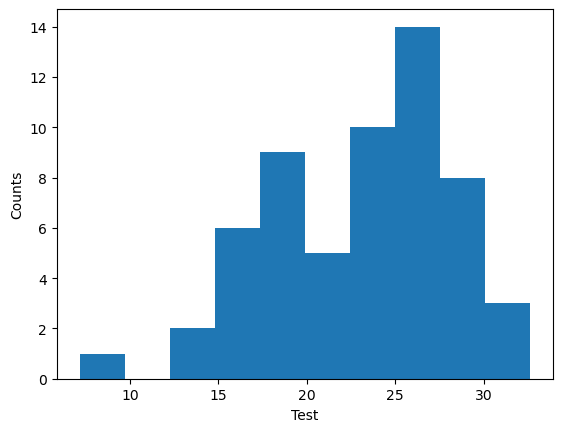

NormaltestResult(statistic=4.237079664918311, pvalue=0.1202070228206594)


In [39]:
# For testing normal distribution of any data
url_path = Path('output_data/housing_clean_data.csv')
housing_test_df = pd.read_csv(url_path)

test_data = housing_test_df['% Units Costs>=30%']
plt.hist(test_data)
plt.xlabel('Test')
plt.ylabel('Counts')
plt.show()
print(st.normaltest(test_data))

In [ ]:
coc_mapping age_data = Path('resources/experiencing_homelessness_age_demographics.csv')

In [41]:
url_path = Path('Resources/experiencing_homelessness_ethnicity.csv')
homeless_df = pd.read_csv(url_path)

homeless_df.head()

,CALENDAR_YEAR,COC_ID,COC_NAME,ETHNICITY,EXPERIENCING_HOMELESSNESS
0,2017,All,California,Hispanic/Latinx,59663
1,2017,All,California,Not Hispanic/Latinx,118412
2,2017,All,California,Unknown,3796
3,2017,CA-500,Santa Clara County CoC,Hispanic/Latinx,5010
4,2017,CA-500,Santa Clara County CoC,Not Hispanic/Latinx,5005


In [43]:
# Clean up data

# Rename existing columns
homeless_df = homeless_df.rename(
    columns = {
        'CALENDAR_YEAR': 'Year',
        'COC_ID': 'CoC Code',
        'COC_NAME': 'CoC',
        'EXPERIENCING_HOMELESSNESS': 'Homeless Count'
    }
)

# Change homeless count data type to integer
homeless_df = homeless_df.loc[homeless_df['Homeless Count']!='*']
homeless_df['Homeless Count'] = homeless_df['Homeless Count'].astype(int)

# Rename multiple CoCs in LA so they roll up into one number per year
la_cocs = ["Glendale CoC (Los Angeles County)",
                   "Pasadena CoC (Los Angeles County)", 
                   "Long Beach CoC (Los Angeles County)"
                  ]
homeless_df['CoC'] = homeless_df['CoC'].replace(la_cocs, "Los Angeles County CoC")

# Group by year and COC name and sum homeless counts
homeless_df = homeless_df.groupby(['Year', 'CoC'])['Homeless Count'].sum().reset_index()

homeless_df

,Year,CoC,Homeless Count
0,2017,Alameda County CoC,6603
1,2017,"Alpine, Inyo, Mono Counties CoC",161
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",383
3,2017,Butte County CoC,1373
4,2017,California,181871
...,...,...,...
245,2022,Stanislaus County CoC,6346
246,2022,Tehama County CoC,668
247,2022,Ventura County CoC,2861
248,2022,Yolo County CoC,1396


In [ ]:
# Housing affordability index 
housing_hai_df = pd.read_excel("resources/housing_hai_data.xlsx")

housing_hai_df